# Cross-validation and polynomial regression

## Polynomial regression

Polynomial regression consists of fitting some data $(x, y)$ to a $n$-order polynomial of the form:

$$
 y = f(x) = b + w_1 \cdot x + w_2 \cdot x^2 + ... + w_n \cdot x^n
$$
 
By rewriting the unidimensional input $x$ into the following vector:

$$
 \mathbf{x} = \begin{bmatrix} x & x^2 & ... & x^n \end{bmatrix}^T
$$

and the weight vector as:

$$
 \mathbf{w} = \begin{bmatrix} w_1 & w_2 & ... & w_n \end{bmatrix}^T
$$
 
the problem can be reduced to linear regression:

$$
 y = \langle \mathbf{w}, \mathbf{x} \rangle + b
$$
 
 and we can apply the delta learning rule to find $\mathbf{w}$ and $b$:

$$
 \Delta \mathbf{w} =  \eta \, (t_i - y_i ) \, \mathbf{x_i}
$$
$$
 \Delta b =  \eta (t_i - y_i ) 
$$

A first method to perform polynomial regression would be to adapt the code you wrote in the last exercise session for linear regression. However, you saw that properly setting the correct learning rate can be quite tricky. 

The solution retained for this exercise is to use the built-in functions of Numpy which can already perform polynomial regression in an optimized and proved-sure manner (Note: NumPy does not use gradient descent, but rather directly minimizes the error-function by inversing the Gram matrix).

```python
w = np.polyfit(X, t, deg)
```

This function takes the inputs $X$, the desired outputs $t$ and the desired degree of the polynomial `deg`, performs the polynomial regression and returns the adequate set of weights (beware: the higher-order coefficient comes first, the bias is last).

Once the weights are obtained, one can use them to predict the value of an example with the function:

```python
y = np.polyval(w, X)
```

*Note:* if you prefer to use scikit-learn, check <https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html> but see <https://towardsdatascience.com/polynomial-regression-with-scikit-learn-what-you-should-know-bed9d3296f2> for why it may be a bad idea.

Let's start by importing the usual stuff and create a dataset of 16 samples generated using the function $x \, \sin x$ plus some noise:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Just to avoid the annoying warnings, please ignore
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
 
def create_dataset(N, noise):
    "Creates a dataset of N points generated from x*sin(x) plus some noise."
    
    x = np.linspace(0, 10, 300)
    rng = np.random.default_rng()
    rng.shuffle(x)
    x = np.sort(x[:N])
    t = x * np.sin(x) + noise*rng.uniform(-1.0, 1.0, N)
    
    return x, t

N = 16
X, t = create_dataset(N, noise=0.2)

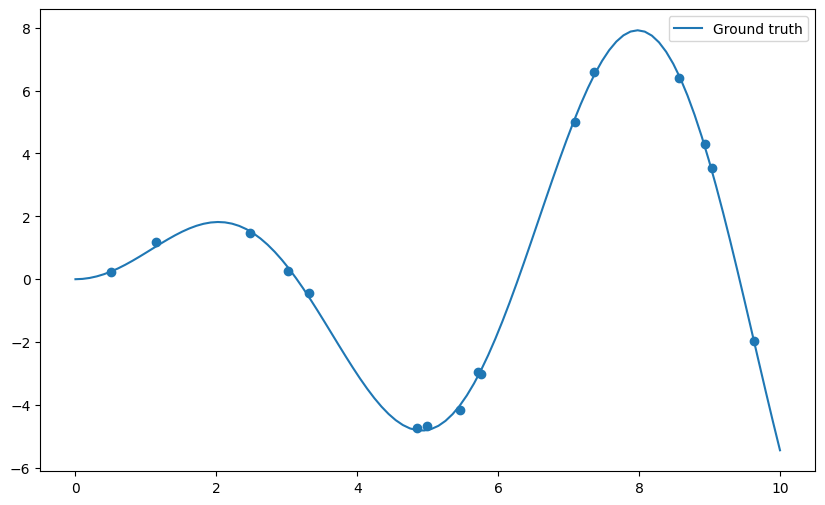

In [2]:
x = np.linspace(0, 10, 100)

plt.figure(figsize=(10, 6))
plt.plot(x, x*np.sin(x), label="Ground truth")
plt.scatter(X, t)
plt.legend()
plt.show()

**Q:** Apply the `np.polyfit()` function on the data and visualize the result for different degrees of the polynomial (from 1 to 20 or even more). What do you observe? Find a polynomial degree which clearly overfits.

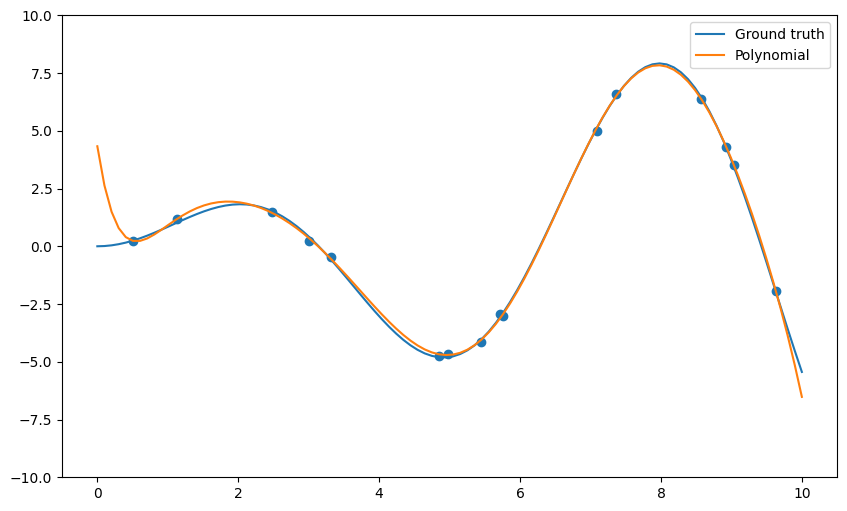

In [3]:
deg = 10

# Polynomial regression
w = np.polyfit(X, t, deg)

# Inference on the training set
y = np.polyval(w, x)

plt.figure(figsize=(10, 6))
plt.plot(x, x*np.sin(x), label="Ground truth")
plt.plot(x, y, label="Polynomial")
plt.scatter(X, t)
plt.ylim((-10., 10.))
plt.legend()
plt.show()

**Q:** Plot the mean square error on the training set for all polynomial regressions from 1 to 20. How does the training error evolve when the degree of the polynomial is increased? What is the risk by taking the hypothesis with the smallest training error? 

Degree 1 : training error 12.567226630311886
Degree 2 : training error 10.483509437648394
Degree 3 : training error 9.274018583489612
Degree 4 : training error 0.9502372573432639
Degree 5 : training error 0.9421944377864839
Degree 6 : training error 0.048188137257714904
Degree 7 : training error 0.018991689605236624
Degree 8 : training error 0.008422829959076068
Degree 9 : training error 0.006164965352148288
Degree 10 : training error 0.006129222809776264
Degree 11 : training error 0.004283848794533064
Degree 12 : training error 0.004087437420506596
Degree 13 : training error 0.002886281881036815
Degree 14 : training error 0.001843354751738063
Degree 15 : training error 0.001859861490643605
Degree 16 : training error 0.0018761576346283428
Degree 17 : training error 5.396287629162066e-08
Degree 18 : training error 2.0214011029583385e-08
Degree 19 : training error 4.444494134139875e-10
Degree 20 : training error 8.380045360407144e-10
Degree with minimal error is 19 with MSE 4.44449413413

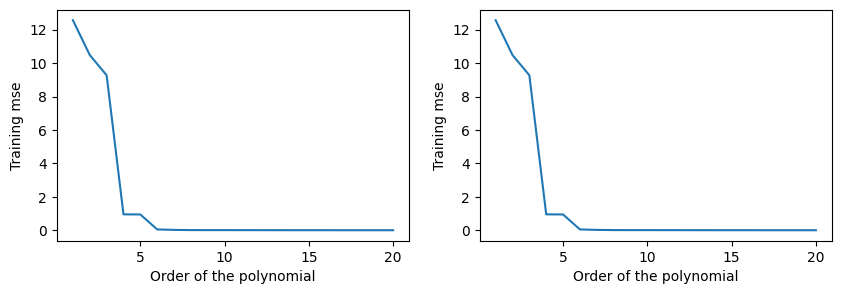

In [4]:
training_mse = []

degrees = range(1, 21)

for deg in degrees:
    
    w = np.polyfit(X, t, deg)
    y = np.polyval(w, X)
    
    mse = np.mean((t-y)**2)
    
    training_mse.append(mse)
    
    print("Degree", deg, ": training error", mse)
    
print(f"Degree with minimal error is {np.argmin(training_mse)+1} with MSE {training_mse[np.argmin(training_mse)]}")

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot(degrees, training_mse)
plt.xlabel("Order of the polynomial")
plt.ylabel("Training mse")

plt.subplot(1,2,2)
plt.plot(degrees, training_mse)
plt.xlabel("Order of the polynomial")
plt.ylabel("Training mse")
plt.show()

**A:** The more complex the model, the smaller the training error.

## Simple hold-out cross-validation

You will now apply **simple hold-out cross-validation** to find the optimal degree for the polynomial regression. You will need to separate the data set into a training set $S_{\text{train}}$ (70% of the data) and a test set $S_{\text{test}}$ (the remaining 30%). 

The data (X, t) could be easily split into two sets of arrays using slices of indices, as the data is already randomized:

```python
N_train = int(0.7*N)
X_train, t_train = X[:N_train], t[:N_train]
X_test, t_test = X[N_train:], t[N_train:]
```

A much more generic approach is to use the library `scikit-learn` (<https://www.scikit-learn.org>), which provides a method able to split any dataset randomly. 

You can import the method `train_test_split()` from its module:

In [5]:
from sklearn.model_selection import train_test_split

The doc of the function is available at: <https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html>.

**Q:** Use scikit-learn to split the data into the corresponding training and test sets. Train each polynomial from degree 1 to 20 on $S_{\text{train}}$ and plot the generalization error on $S_{\text{test}}$. Which degree of the polynomial gives the minimal empirical error? Why? Run the cross-validation split multiple times. Do you always obtain the same optimal degree? 

Degree 1 : empirical error 18.393410955299807
Degree 2 : empirical error 35.19415390842666
Degree 3 : empirical error 34.31870060747521
Degree 4 : empirical error 15.256979698023045
Degree 5 : empirical error 14.84812992204784
Degree 6 : empirical error 8.153588267740952
Degree 7 : empirical error 5.595444721613335
Degree 8 : empirical error 51.917552713302186
Degree 9 : empirical error 7768.61031742412
Degree 10 : empirical error 85033353.24748924
Degree 11 : empirical error 47711316.97161055
Degree 12 : empirical error 35636044.901613176
Degree 13 : empirical error 37096931.497372754
Degree 14 : empirical error 48819390.153693825
Degree 15 : empirical error 71671763.42178875
Degree 16 : empirical error 109429764.43453725
Degree 17 : empirical error 168855338.05660886
Degree 18 : empirical error 260542707.72495556
Degree 19 : empirical error 400431620.8822564
Degree 20 : empirical error 612087519.6221578
Degree with minimal error is 7 with MSE 5.595444721613335


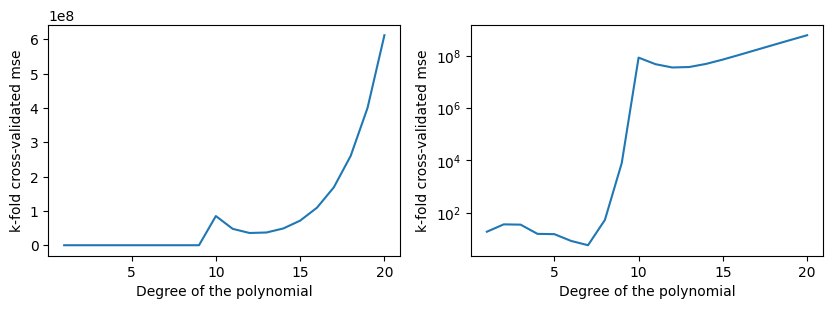

In [6]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3)

degrees = range(1, 21)

test_mse = []

for deg in degrees:
    # Train on the training set
    w = np.polyfit(X_train, t_train, deg)
    
    # Test on the test set
    y_test = np.polyval(w, X_test)
    mse = np.mean((t_test-y_test)**2)
    test_mse.append(mse)
    
    print("Degree", deg, ": empirical error", mse)
    
print(f"Degree with minimal error is {np.argmin(test_mse)+1} with MSE {test_mse[np.argmin(test_mse)]}")

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(degrees, test_mse)
plt.xlabel("Degree of the polynomial")
plt.ylabel("k-fold cross-validated mse")

plt.subplot(1,2,2)
plt.semilogy(degrees, test_mse)
plt.xlabel("Degree of the polynomial")
plt.ylabel("k-fold cross-validated mse")
plt.show()

**A:** Depending on the split, the optimal degree is around 6 or 7. This variability is because some samples of the test set might better fit with a given polynomial, depending on how the split was made.  

## k-fold cross-validation

As we only have 16 samples to learn from, it is quite annoying to "lose" 5 of them for the test set. Here we can afford to use **k-fold cross-validation**, where the cross-validation split is performed $k$ times:

* The dataset is split into $k$ subsets of equal size (if possible).
* Each subset is iteratively used as the test set, while the $k-1$ other ones are used as a training set.
* The final empirical error is the average of the mse on all subsets.

It would be possible to make the splits using indices too, but it is much easier to use `scikit-learn` once again. You can import the `KFold` class like this:

In [7]:
from sklearn.model_selection import KFold

k = 4
kf = KFold(n_splits=k, shuffle=True)

`n_splits` corresponds to $k$: how many times the dataset is split. We can take $k=4$ for example (4 subsets of 4 samples).

**Q:** Check the doc of `KFold` (<https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html>). Print the indices of the examples of the training and test sets for each iteration of the algorithm. Change the value of $k$ to understand how it works.

In [8]:
for train_index, test_index in kf.split(X, t):
    print("Train:", train_index)
    print("Test:", test_index)
    print('-------')

Train: [ 0  1  2  3  6  8  9 10 11 13 14 15]
Test: [ 4  5  7 12]
-------
Train: [ 1  2  4  5  6  7  8 11 12 13 14 15]
Test: [ 0  3  9 10]
-------
Train: [ 0  2  3  4  5  6  7  9 10 12 13 14]
Test: [ 1  8 11 15]
-------
Train: [ 0  1  3  4  5  7  8  9 10 11 12 15]
Test: [ 2  6 13 14]
-------


**Q:** Apply k-fold cross-validation on the polynomial regression problem. Which polynomial degree is the best? Run the split multiple times: does the best polynomial degree change?

Degree with minimal error is 7 with MSE 2.1460310524175936
1 13.02790496373238
2 13.403141832266606
3 18.279608115706804
4 3.7079686609417544
5 20.48490044046009
6 4.714716164201406
7 2.1460310524175936
8 6.661006480869433
9 43.324568274476725
10 33294.39354468571
11 413419266.43836355
12 181393171.62402347
13 87020925.93274486
14 47005721.110629894
15 30531001.15949266
16 25746972.68914536
17 28284805.25184955
18 37134779.74488291
19 53182837.818296604
20 78808997.32572207


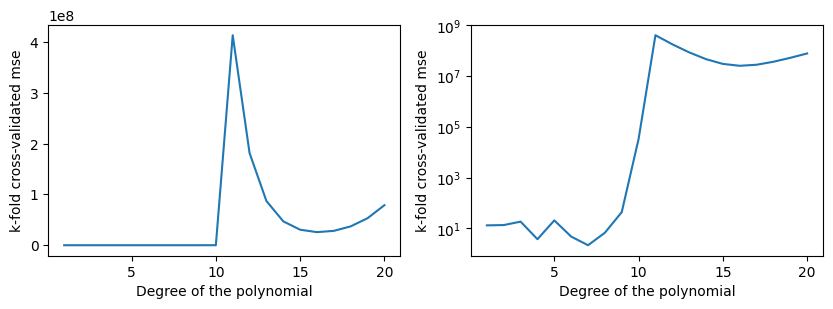

In [9]:
k = 4
kf = KFold(n_splits=k, shuffle=True)

degrees = range(1, 21)

test_mse = []

for train_index, test_index in kf.split(X, t):
    
    split_mse = []
    
    for deg in degrees:
        
        w = np.polyfit(X[train_index], t[train_index], deg)
        y = np.polyval(w, X[test_index])
        
        mse = np.mean((t[test_index] - y)**2)
        split_mse.append(mse)
    
    test_mse.append(split_mse)
        
test_mse = np.mean(test_mse, axis=0)

print(f"Degree with minimal error is {np.argmin(test_mse)+1} with MSE {test_mse[np.argmin(test_mse)]}")

for deg, mse in zip(degrees, test_mse):
    print(deg, mse)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(degrees, test_mse)
plt.xlabel("Degree of the polynomial")
plt.ylabel("k-fold cross-validated mse")

plt.subplot(1,2,2)
plt.semilogy(degrees, test_mse)
plt.xlabel("Degree of the polynomial")
plt.ylabel("k-fold cross-validated mse")
plt.show()

**A:** A polynomial of order between 6 and 8 still seems the best, but it varies from run to run (as well as on the data, you may observe something different).

**Q:** Change $k$ to $N$. How stable are the results between two runs?

Degree with minimal error is 6 with MSE 2.9708859823783427
1 15.881353205792308
2 16.898336120741803
3 23.532698385348702
4 4.258030463879448
5 17.50251068392804
6 2.9708859823783427
7 3.4773234866151084
8 8.473572046785709
9 42.69425947678192
10 898.5333600359328
11 324.0245653672319
12 164864.18395029468
13 30487122.324273504
14 54276479.177794114
15 76368005957.03314
16 35360616638.78458
17 17330870599.225636
18 9033919298.222765
19 5109433893.348246
20 3282468516.502675


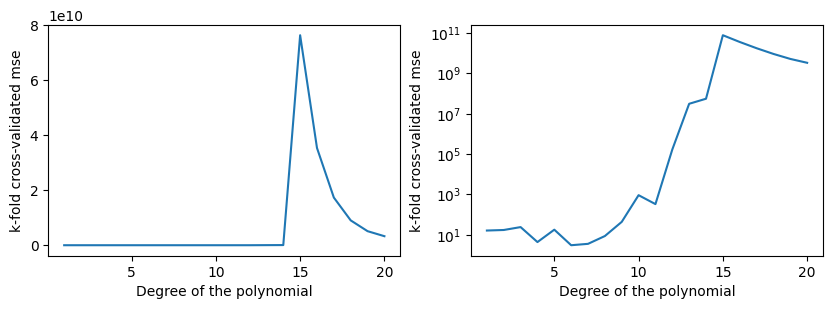

In [10]:
k = N
kf = KFold(n_splits=k, shuffle=True)

degrees = range(1, 21)

test_mse = []

for train_index, test_index in kf.split(X, t):
    
    split_mse = []
    
    for deg in degrees:
        
        w = np.polyfit(X[train_index], t[train_index], deg)
        y = np.polyval(w, X[test_index])
        
        mse = np.mean((t[test_index] - y)**2)
        split_mse.append(mse)
    
    test_mse.append(split_mse)
        
test_mse = np.mean(test_mse, axis=0)

print(f"Degree with minimal error is {np.argmin(test_mse)+1} with MSE {test_mse[np.argmin(test_mse)]}")

for deg, mse in zip(degrees, test_mse):
    print(deg, mse)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(degrees, test_mse)
plt.xlabel("Degree of the polynomial")
plt.ylabel("k-fold cross-validated mse")

plt.subplot(1,2,2)
plt.semilogy(degrees, test_mse)
plt.xlabel("Degree of the polynomial")
plt.ylabel("k-fold cross-validated mse")
plt.show()

**A:** With $k=N$ (one sample in the test set every time), the results are more stable. It is called **leave-one-out cross-validation** (LOOCV). It is the best cross-validation you can make in terms of bias (you use almost all your data to learn), but it is very expensive (you have to retrain your algorithm for each sample) and the empirical error has a high variance.

**Q:** Regenerate the data with a noise equal to 0.0 and re-run all experiments. What does it change?

**A:** Without noise, higher-order polynomials are a better fit. This is because the $x \, \sin x$ can be "naturally" approximated by polynomials (Taylor series).